In [1]:
import gymnasium as gym
import numpy as np
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [2]:
import gc
gc.collect()

7

In [3]:
!nvidia-smi

# clean up memory forcefully
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device





Sun Apr 14 20:26:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  8%   53C    P2              58W / 250W |    494MiB / 11264MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self,  output_dim):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, output_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x

    

Using device: cuda


In [5]:
from stable_baselines3.common.env_util import make_atari_env
env_id="MsPacmanNoFrameskip-v4"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
# print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_atari_env(env_id, n_envs=1)
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
env = VecTransposeImage(env)            # 确保图像通道在前
env = VecFrameStack(env, n_stack=4)     # 堆叠4帧
obs = env.reset()
print(obs.shape)
# print(env.action_space.n)
# print(env.observation_space.shape[0])

(100000, 4, 84, 84) (100000,) (100000,) (100000,) (100000,) (100000, 4, 84, 84)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


(1, 4, 84, 84)


In [6]:
obs = env.reset()
print(obs.shape)

(1, 4, 84, 84)


In [7]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32)
        self.actions = torch.tensor(actions, dtype=torch.float32)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [8]:

policy_network = PolicyNetwork(env.action_space.n).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.conv1.weight)
torch.nn.init.kaiming_normal_(policy_network.conv2.weight)
torch.nn.init.kaiming_normal_(policy_network.conv3.weight)
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)



train_dataset = CustomDataset(observations, actions)

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-4,weight_decay=1e-5)


# Training loop
num_epochs = 60
batch_size = 128

train_dataloader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset , batch_size=batch_size, shuffle=True)
loss_func = nn.CrossEntropyLoss()
log_interval = len(observations)//10
num_test=1

now_log=0
now_pos=0
graph=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(train_dataloader,position=0,leave=True)
    now_log=0
    now_pos=0
    for step, (obs_batch,act_batch) in enumerate(pbar):
        obs_batch=obs_batch.to(device)
        act_batch=act_batch.to(device)
        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        # cross entropy
        loss=loss_func(logits, act_batch.long())
        
        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()




        #scheduler

        graph.append(loss.detach().item())
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"epoch_{epoch+1}_iteration_{now_pos}.gif"
                    imageio.mimsave("./gif/"+image_path, frames)


            
            print(total_reward/num_test)
                
            eval_rewards.append(total_reward/num_test)

            policy_network.train()      
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        pbar.set_postfix({"loss":loss.detach().item()})
env.close()

    


OutOfMemoryError: CUDA out of memory. Tried to allocate 10.52 GiB. GPU 0 has a total capacity of 10.91 GiB of which 10.27 GiB is free. Process 1654141 has 244.00 MiB memory in use. Process 1677689 has 246.00 MiB memory in use. Including non-PyTorch memory, this process has 160.00 MiB memory in use. Of the allocated memory 6.44 MiB is allocated by PyTorch, and 15.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

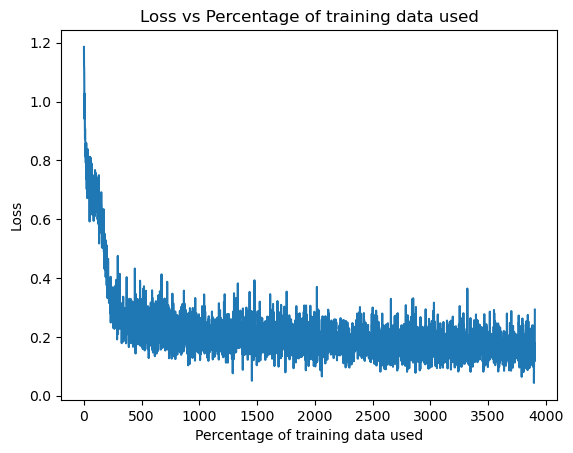

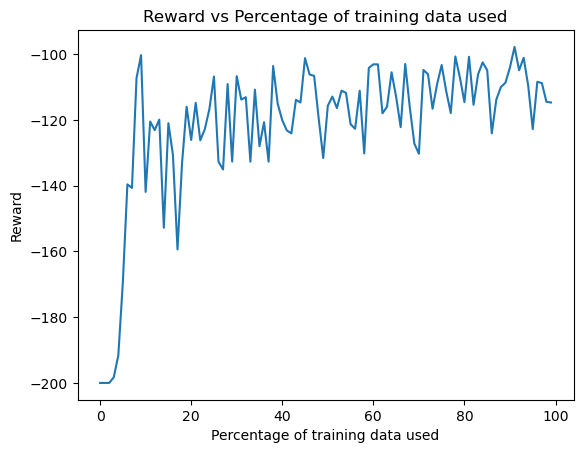

In [ ]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("Percentage of training data used")
plt.ylabel("Loss")
plt.title("Loss vs Percentage of training data used")

plt.savefig("./loss.png")
plt.show()
# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("Percentage of training data used")
plt.ylabel("Reward")
plt.title("Reward vs Percentage of training data used")
plt.savefig("./reward.png")
plt.show()


